<a href="https://www.kaggle.com/code/alexefimik/sigma-cabs-surge-pricing-prediction-68-accuracy?scriptVersionId=122773658" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<img src="https://media.discordapp.net/attachments/1004748557477224498/1087138296477532243/MAD_Web_illustration_for_data_taxi_299ed35e-f711-4f19-8747-d4604bfc8c9b.png?width=1206&height=676" width="600" align="center"/>

# Sigma Cabs Surge Pricing Prediction

This dataset, provided by an Indian cab aggregator service called Sigma Cabs, contains data about their customers and trips. The main objective is to build a predictive model to predict the surge_pricing_type pro-actively, which would help match the right cabs with the right customers quickly and efficiently.

Possible analyses and tasks with this dataset include:

- Exploratory Data Analysis (EDA)
- Customer (trips) Segmentation
- Predicting the pricing\_type (Multi-classification)
- Interpretations based on algorithms outputs

## Importing data

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Set random seed for reproducibility
np.random.seed(2022)

# Import components of the scikit-learn library
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.calibration import CalibrationDisplay, calibration_curve

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/kaggle/input/taxi-pricing-with-mobility-analytics/sigma_cabs.csv')
df.shape

(131662, 14)

In [3]:
# Creating index column
df = df.set_index('Trip_ID')
df.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
Trip_ID,,,,,,,,,,,,,
T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


The dataset has the following features:

1. Trip\_ID: ID for the trip
2. Trip\_Distance: The distance for the trip requested by the customer
3. Type\_of\_Cab: Category of the cab requested by the customer
4. Customer\_Since\_Months: Customer using cab services since n months; 0 month means current month
5. Life\_Style\_Index: Proprietary index created by Sigma Cabs showing the lifestyle of the customer based on their behavior
6. Confidence\_Life\_Style\_Index: Category showing confidence on the index mentioned above
7. Destination\_Type: Sigma Cabs divides any destination into one of the 14 categories.
8. Customer\_Rating: Average of lifetime ratings of the customer till date
9. Cancellation\_Last\_1Month: Number of trips canceled by the customer in the last 1 month
10. Var1, Var2, and Var3: Continuous variables masked by the company. Can be used for modeling purposes
11. Gender: Gender of the customer
12. Surge\_Pricing\_Type: Target (can be of 3 types)

## Working with missing data

In [4]:
# Let's see the missing values
df.isnull().sum()

Trip_Distance                      0
Type_of_Cab                    20210
Customer_Since_Months           5920
Life_Style_Index               20193
Confidence_Life_Style_Index    20193
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                           71030
Var2                               0
Var3                               0
Gender                             0
Surge_Pricing_Type                 0
dtype: int64

### Vizualization

<AxesSubplot:>

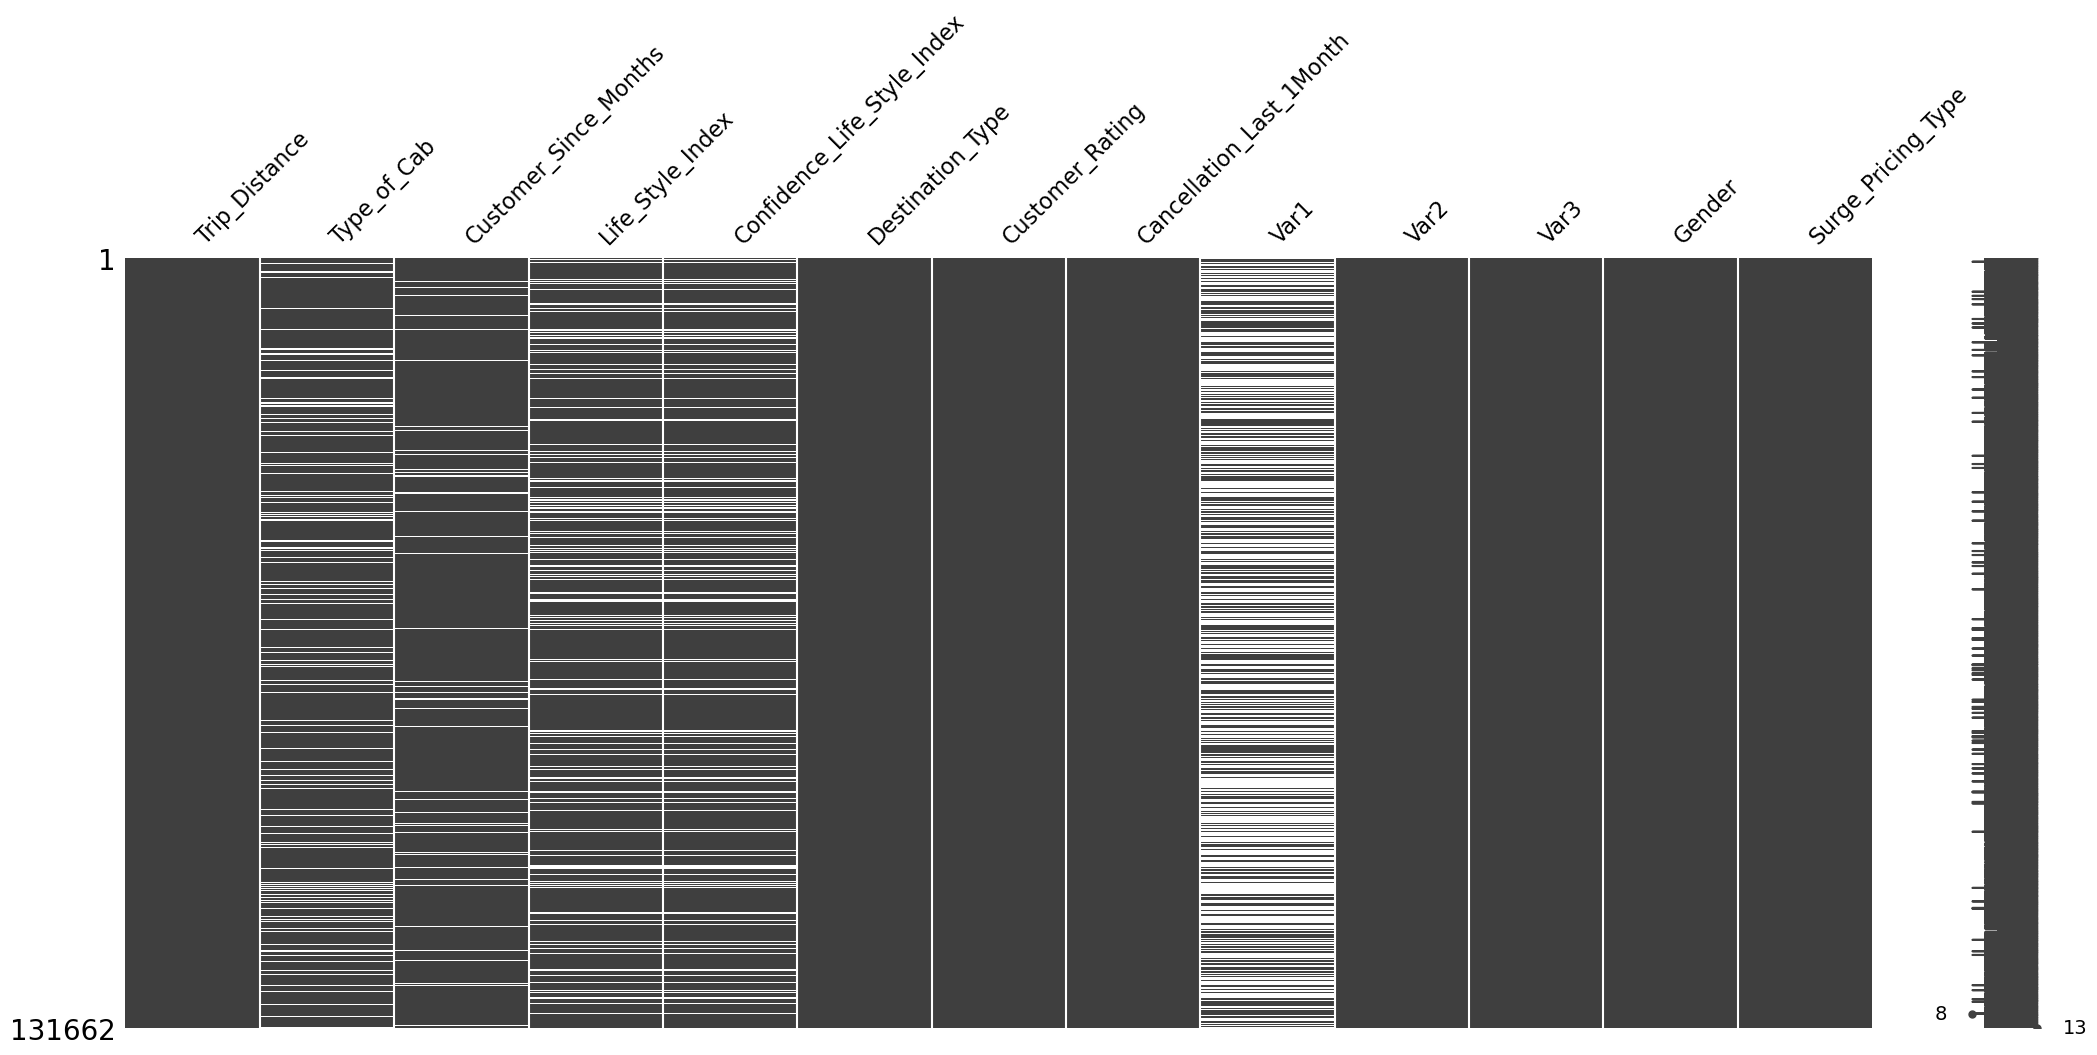

In [5]:
# Visualize missing values as a matrix
msno.matrix(df)

<AxesSubplot:>

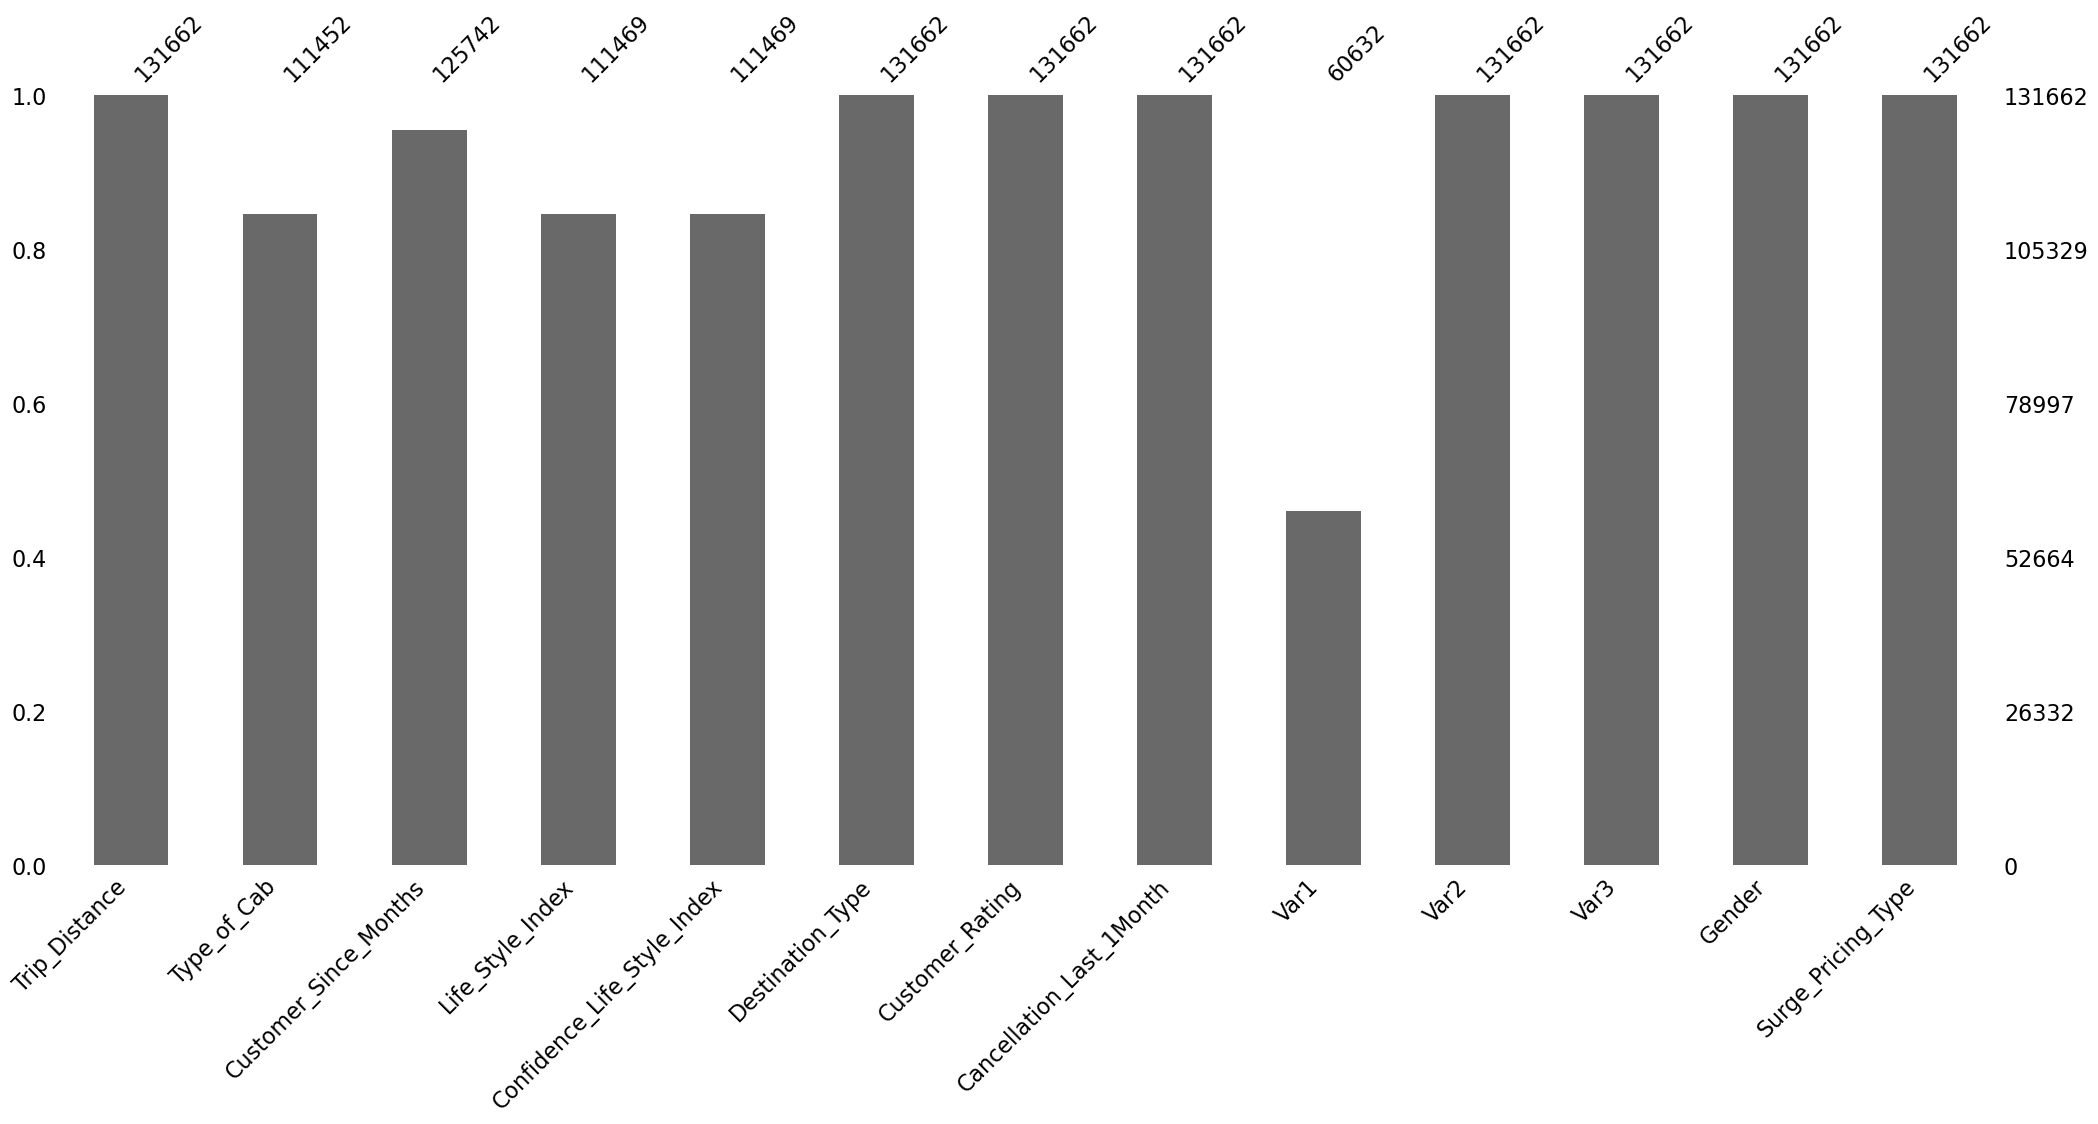

In [6]:
# Visualize missing values as a bar chart
msno.bar(df)

### Mapping of the columns

In [7]:
# Define numeric columns
numeric_columns = df.loc[:,df.dtypes!=object].columns
df.loc[:,df.dtypes!=object].head(2)

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Surge_Pricing_Type
Trip_ID,,,,,,,,,
T0005689460,6.77,1.0,2.42769,3.905,0,40.0,46,60,2
T0005689461,29.47,10.0,2.78245,3.450,0,38.0,56,78,2


In [8]:
# Define categorical columns
categorical_columns = df.loc[:,df.dtypes==object].columns
df.loc[:,df.dtypes==object].head(2)

,Type_of_Cab,Confidence_Life_Style_Index,Destination_Type,Gender
Trip_ID,,,,
T0005689460,B,A,A,Female
T0005689461,B,B,A,Male


### Replacing missing values

In [9]:
# Replace missing values with mean value in numerical columns
for col in numeric_columns:
    df[col] = df[col].fillna(df[col].mean())

# Fill missing values in categorical columns with the most frequent value
for col in categorical_columns:
    most_frequent = df[col].mode()[0]
    df[col] = df[col].fillna(most_frequent)

In [10]:
# Check the number of missing values in each column
df.isnull().sum()

Trip_Distance                  0
Type_of_Cab                    0
Customer_Since_Months          0
Life_Style_Index               0
Confidence_Life_Style_Index    0
Destination_Type               0
Customer_Rating                0
Cancellation_Last_1Month       0
Var1                           0
Var2                           0
Var3                           0
Gender                         0
Surge_Pricing_Type             0
dtype: int64

## EDA

### Building the correlation matrix

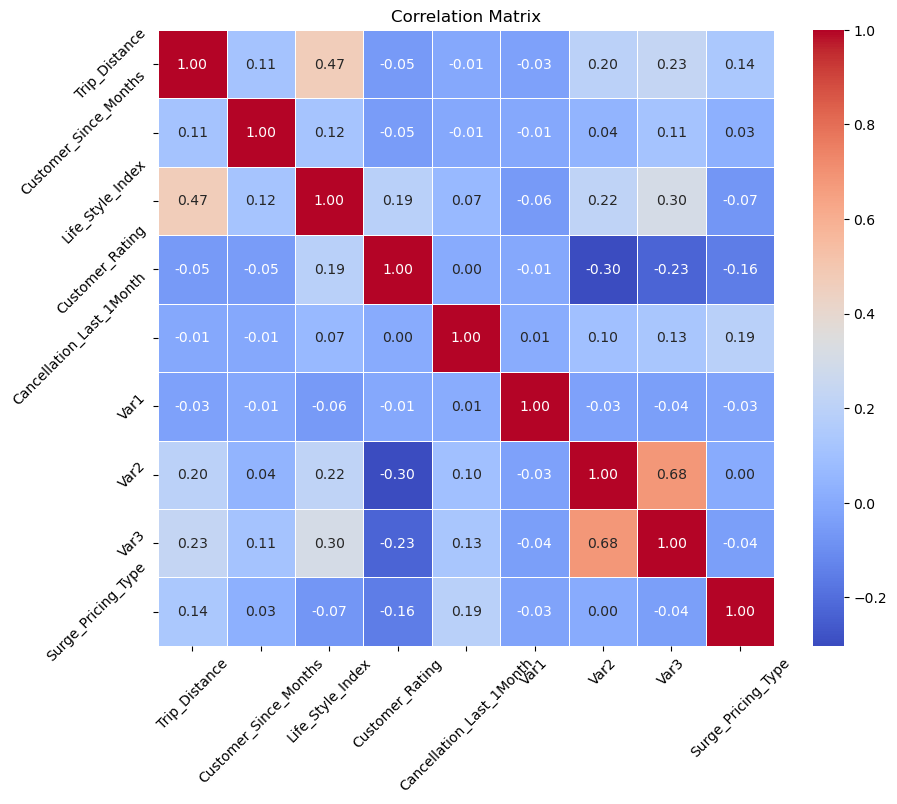

In [11]:
# Build the correlation matrix
correlation_matrix = df[numeric_columns].corr()

# Set the size of the plot
plt.figure(figsize=(10, 8))

# Visualize the correlation matrix using a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, square=True)

# Set title and axes
plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Display the plot
plt.show()


In [12]:
# The following line creates a sorted list of correlations between all pairs of columns in a correlation matrix, sorted by absolute value in descending order.
sorted_correlations = correlation_matrix.unstack().sort_values(ascending=False, key=abs)

# The next line selects the top 10 pairs of columns with the highest correlation values, excluding perfect correlations of 1.0.
top_5_correlations = sorted_correlations[sorted_correlations < 1].head(10)

# Finally, we print the resulting list of top correlations.
print(top_5_correlations)


Var2              Var3                0.683437
Var3              Var2                0.683437
Trip_Distance     Life_Style_Index    0.468367
Life_Style_Index  Trip_Distance       0.468367
Var3              Life_Style_Index    0.303296
Life_Style_Index  Var3                0.303296
Var2              Customer_Rating    -0.302968
Customer_Rating   Var2               -0.302968
Var3              Trip_Distance       0.231706
Trip_Distance     Var3                0.231706
dtype: float64


In summary, this code creates a list of the highest correlations between pairs of columns in a correlation matrix, sorted by absolute value, and prints the top 10 correlations (excluding perfect correlations of 1.0).

### Using ONE-HOT encoding for the categorical columns

In [13]:
# Print the head of categorical features
df[categorical_columns].head()

,Type_of_Cab,Confidence_Life_Style_Index,Destination_Type,Gender
Trip_ID,,,,
T0005689460,B,A,A,Female
T0005689461,B,B,A,Male
T0005689464,B,B,E,Male
T0005689465,C,B,A,Male
T0005689467,C,B,A,Male


In [14]:
# One-Hot-Encoding
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
df_encoded.head()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Surge_Pricing_Type,Type_of_Cab_B,...,Destination_Type_F,Destination_Type_G,Destination_Type_H,Destination_Type_I,Destination_Type_J,Destination_Type_K,Destination_Type_L,Destination_Type_M,Destination_Type_N,Gender_Male
Trip_ID,,,,,,,,,,,,,,,,,,,,,
T0005689460,6.77,1.0,2.427690,3.90500,0,40.000000,46,60,2,1,...,0,0,0,0,0,0,0,0,0,0
T0005689461,29.47,10.0,2.782450,3.45000,0,38.000000,56,78,2,1,...,0,0,0,0,0,0,0,0,0,1
T0005689464,41.58,10.0,2.802064,3.50125,2,64.202698,56,77,2,1,...,0,0,0,0,0,0,0,0,0,1
T0005689465,61.56,10.0,2.802064,3.45375,0,64.202698,52,74,3,0,...,0,0,0,0,0,0,0,0,0,1
T0005689467,54.95,10.0,3.034530,3.40250,4,51.000000,49,102,2,0,...,0,0,0,0,0,0,0,0,0,1


This code will perform One-Hot-Encoding on the categorical columns in a dataframe named `df`, drop the first column to avoid multicollinearity, and store the result in a new dataframe named `df_encoded`. The code will then print the first few rows of the encoded dataframe.

Now we have a preprocessed dataset with filled missing values and encoded categorical features, which can be used for further analysis or modeling.

## Training

This code separates the preprocessed dataset into features and the target variable, and then uses the `train_test_split()` function from scikit-learn to split the data into training and testing sets. The test size is set to 20% of the total dataset, the data is shuffled randomly, and a fixed seed value of 2022 is used to ensure reproducibility. The resulting X\_train, X\_test, y\_train, and y\_test variables can be used for machine learning modeling.

In [15]:
# Separate the dataset into features and target variable
X = df_encoded.drop('Surge_Pricing_Type', axis=1)

# 'Surge_Pricing_Type' is the target variable
y = df_encoded['Surge_Pricing_Type']

# Split the dataset into training and testing sets with a test size of 20%, shuffled randomly with a fixed seed value for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2022)


This code creates a pipeline for preprocessing the data with a StandardScaler and then fitting a One-vs-Rest Logistic Regression Classifier to the transformed data. The `Pipeline()` function from scikit-learn is used to create the pipeline, and the `StandardScaler()` and `OneVsRestClassifier(LogisticRegression())` functions are specified as the preprocessing and classification steps, respectively.

In [16]:
# Create a pipeline with a StandardScaler and a One-vs-Rest Logistic Regression Classifier
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('one_vs_all', OneVsRestClassifier(LogisticRegression()))
])

In [17]:
# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_all',
                 OneVsRestClassifier(estimator=LogisticRegression()))])

In [18]:
# Use the fitted pipeline to make predictions on the test data
y_pred = pipe.predict(X_test)

# Print the classification report for the predictions, with 3 decimal places
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           1      0.722     0.542     0.619      5372
           2      0.636     0.835     0.722     11349
           3      0.741     0.571     0.645      9612

    accuracy                          0.679     26333
   macro avg      0.700     0.649     0.662     26333
weighted avg      0.692     0.679     0.673     26333



In this experiment, we trained a One-vs-Rest Logistic Regression model with standardized data using the StandardScaler. We evaluated the model's performance on a test set with a size of 26,333 samples. The key metrics used for evaluation are precision, recall, and f1-score, which were averaged across all classes using micro, macro, and weighted avg methods. The results obtained are as follows:

- Class 1:
    - Precision: 0.722
    - Recall: 0.542
    - F1-score: 0.619
- Class 2:
    - Precision: 0.636
    - Recall: 0.835
    - F1-score: 0.722
- Class 3:
    - Precision: 0.741
    - Recall: 0.571
    - F1-score: 0.645

Overall model performance:

- Accuracy: 0.679
- Macro avg:
    - Precision: 0.700
    - Recall: 0.649
    - F1-score: 0.662
- Weighted avg:
    - Precision: 0.692
    - Recall: 0.679
    - F1-score: 0.673

The model demonstrates a good overall performance, with higher precision for classes 1 and 3, and higher recall for class 2. The f1-scores, which combine both precision and recall, indicate that the model performs best on class 2, followed by class 3, and then class 1. To further improve the model's performance, one could consider hyperparameter tuning or exploring other algorithms.

## Hyperparameter tuning

In [19]:
# Define the hyperparameter grid for the One-vs-Rest Logistic Regression Classifier
param_grid = {
    'one_vs_all__estimator__penalty': ['l1', 'l2', 'elasticnet'],
    'one_vs_all__estimator__C': [0.001, 0.01, 0.1, 1]
}

# Create a GridSearchCV object with the pipeline `pipe` and the hyperparameter grid `param_grid`
search = GridSearchCV(pipe, param_grid)

# Fit the GridSearchCV object to the training data
search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding mean cross-validation score
print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)


Best parameter (CV score=0.68075):
{'one_vs_all__estimator__C': 0.001, 'one_vs_all__estimator__penalty': 'l2'}


This code defines a hyperparameter grid for the One-vs-Rest Logistic Regression Classifier, which includes values for the `penalty` and `C` hyperparameters. A GridSearchCV object is created with the pipeline `pipe` and the hyperparameter grid `param_grid`, and the object is fit to the training data using the `fit()` method. The best hyperparameters and the corresponding mean cross-validation score are then printed using the `best_params_` and `best_score_` attributes of the GridSearchCV object, respectively.

In [20]:
# Set the pipeline hyperparameters to the best hyperparameters found by GridSearchCV
pipe.set_params(**search.best_params_)

# Fit the pipeline to the training data using the best hyperparameters
pipe.fit(X_train, y_train)

# Use the fitted pipeline to make predictions on the test data
y_pred = pipe.predict(X_test)

# Print the classification report for the predictions, with 3 decimal places
print(classification_report(y_test, y_pred, digits=3))


              precision    recall  f1-score   support

           1      0.741     0.534     0.621      5372
           2      0.635     0.839     0.723     11349
           3      0.742     0.576     0.648      9612

    accuracy                          0.681     26333
   macro avg      0.706     0.650     0.664     26333
weighted avg      0.696     0.681     0.675     26333



In this experiment, we performed hyperparameter tuning for the One-vs-Rest Logistic Regression Classifier using GridSearchCV. By searching for the best combination of penalty and C hyperparameters, we aimed to improve the model's performance.

After hyperparameter tuning, we observed an improvement in the model's performance. The precision for class 1 increased from 0.722 to 0.741, and the f1-scores for all three classes slightly improved. The overall accuracy also increased from 0.679 to 0.681.

Hyperparameter tuning has helped to enhance the model's performance, but the improvement is not substantial. Additional approaches, such as feature selection, dimensionality reduction, or testing other machine learning algorithms, can be explored to further optimize the model's performance.

### Calibration curve & ROC-AUC

Calibration curves help evaluate the quality of predicted probabilities, while ROC-AUC graphs help visualize the trade-offs between true positive and false positive rates

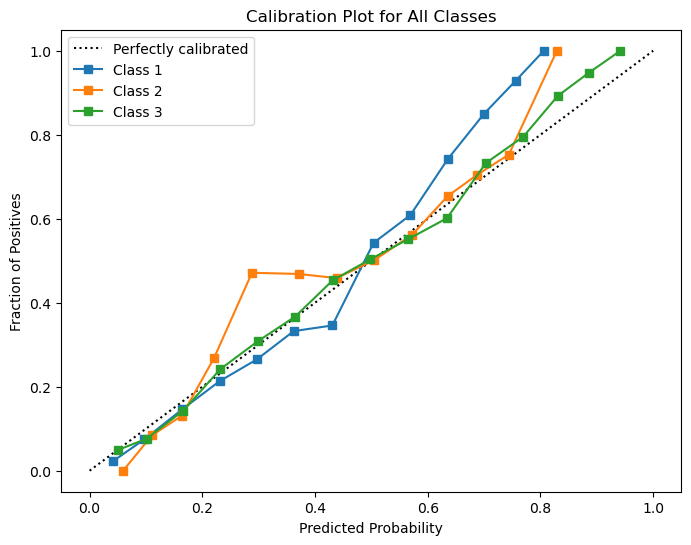

In [21]:
def Calibrator(X_test, y_test, estimator):
    y_pred = estimator.predict_proba(X_test)
    y_true = pd.get_dummies(y_test)

    # Create a figure and axes for the calibration plots
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create a calibration plot for each class
    for klass in range(3):
        y_klass = np.array([])
        for i in range((y_pred.shape[0])):
            y_klass = np.append(y_klass, y_pred[i][klass])
        # Use ax=ax to add the plots to the same axes
        CalibrationDisplay.from_predictions(y_true[klass+1], y_klass, n_bins=15, ax=ax, name=f'Class {klass+1}')

    # Add a legend, title, and axis labels
    ax.legend()
    ax.set_title('Calibration Plot for All Classes')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Fraction of Positives')

    # Display the plot
    plt.show()

# Call the function with the pipeline and test data
Calibrator(X_test, y_test, pipe)


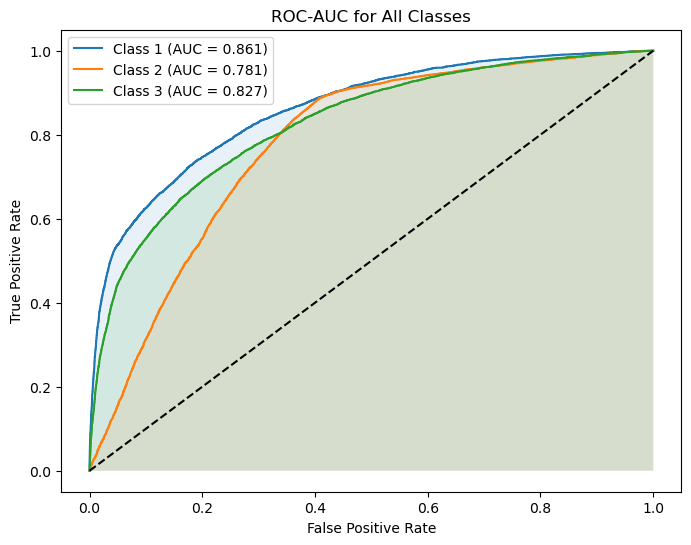

In [22]:
# Use the GridSearchCV object to make predictions on the test data
y_pred = search.predict_proba(X_test)
y_true = pd.get_dummies(y_test)

def RocAuc(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    return fpr, tpr, auc(fpr, tpr)

# Create a figure and axes for the ROC-AUC plots
fig, ax = plt.subplots(figsize=(8, 6))

# Create a ROC-AUC plot for each class
for klass in range(3):
    y_klass = np.array([])
    for i in range((y_pred.shape[0])):
        y_klass = np.append(y_klass, y_pred[i][klass])
    fpr, tpr, auc_value = RocAuc(y_true[klass+1], y_klass)
    ax.plot(fpr, tpr, label=f'Class {klass+1} (AUC = {round(auc_value, 3)})')
    ax.fill_between(fpr, tpr, alpha=0.1)

# Add a dashed line at 45 degrees
ax.plot([0, 1], [0, 1], linestyle='--', color='black')

# Add a legend, title, and axis labels
ax.legend()
ax.set_title('ROC-AUC for All Classes')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# Display the plot
plt.show()


### Using polynomial features up to the 4th degree

In this experiment, we trained a logistic regression model with hyperparameters from the first task using polynomial features up to the 4th degree. By introducing polynomial features, we aimed to capture potential nonlinear relationships between the input features and the target variable. This can help improve the model's performance, as real-world data often exhibits complex, nonlinear dependencies that linear models, like logistic regression, might not fully account for.

Example: Let's suppose we have a single feature

$$
d_j = [1, 2, 3, 4]
$$

Then the polynomial features up to degree 4 of this feature would be:

$$
d_j^1 = [1, 2, 3, 4]
$$

$$
d_j^2 = [1, 4, 9, 16]
$$

$$
d_j^3 = [1, 8, 27, 64]
$$

$$
d_j^4 = [1, 16, 81, 256]
$$

Note that binary columns do not need to be raised to any power, so we will only take the continuous features from the original set.


In [23]:
# Create a copy of the original dataset
X_polinomial = X.copy()

In [24]:
# Get the names of the non-binary columns
nonbin = X.nunique() > 2
nonbin = nonbin[nonbin == True].index.to_list()

# Iterate over all non-binary numeric columns
for col in nonbin:
    # Raise the numeric columns to the 2nd, 3rd, and 4th powers
    for power in [2, 3, 4]:
        # Compute the column with the raised values and rename it
        to_add = (X_polinomial[col] ** power).to_frame().rename({col: f"{col}_{power}"}, axis=1)
        # Add the new column to X_polinomial by concatenating horizontally
        X_polinomial = pd.concat((X_polinomial, to_add), axis=1)

This code uses the `X.nunique()` method to get the number of unique values in each column of the original dataset `X`. The `> 2` condition is used to identify non-binary columns (i.e., those with more than 2 unique values). The non-binary columns are then iterated over using a `for` loop, and each non-binary column is raised to the 2nd, 3rd, and 4th powers using another `for` loop. The resulting columns with raised values are then renamed and added to `X_polinomial` using `pd.concat()`. The result is a new dataset `X_polinomial` with polynomial features.

In [25]:
# Split the polynomial feature dataset and target variable into training and test sets
X_pol_train, X_pol_test, y_train, y_test = train_test_split(X_polinomial, y, 
                                                            test_size=0.2, 
                                                            shuffle=True, 
                                                            random_state=2022)

This code uses the `train_test_split()` function from scikit-learn to split the polynomial feature dataset `X_polinomial` and target variable `y` into training and test sets. The training set contains 80% of the data, and the remaining 20% are assigned to the test set. The `shuffle` parameter is set to `True` to ensure that the data is shuffled before being split, and the `random_state` parameter is set to `2022` to ensure reproducibility.

In [26]:
X_polinomial.head()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Type_of_Cab_B,Type_of_Cab_C,...,Cancellation_Last_1Month_4,Var1_2,Var1_3,Var1_4,Var2_2,Var2_3,Var2_4,Var3_2,Var3_3,Var3_4
Trip_ID,,,,,,,,,,,,,,,,,,,,,
T0005689460,6.77,1.0,2.427690,3.90500,0,40.000000,46,60,1,0,...,0,1600.000000,64000.000000,2.560000e+06,2116,97336,4477456,3600,216000,12960000
T0005689461,29.47,10.0,2.782450,3.45000,0,38.000000,56,78,1,0,...,0,1444.000000,54872.000000,2.085136e+06,3136,175616,9834496,6084,474552,37015056
T0005689464,41.58,10.0,2.802064,3.50125,2,64.202698,56,77,1,0,...,16,4121.986462,264642.652988,1.699077e+07,3136,175616,9834496,5929,456533,35153041
T0005689465,61.56,10.0,2.802064,3.45375,0,64.202698,52,74,0,1,...,0,4121.986462,264642.652988,1.699077e+07,2704,140608,7311616,5476,405224,29986576
T0005689467,54.95,10.0,3.034530,3.40250,4,51.000000,49,102,0,1,...,256,2601.000000,132651.000000,6.765201e+06,2401,117649,5764801,10404,1061208,108243216


In [27]:
X_pol_test

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Type_of_Cab_B,Type_of_Cab_C,...,Cancellation_Last_1Month_4,Var1_2,Var1_3,Var1_4,Var2_2,Var2_3,Var2_4,Var3_2,Var3_3,Var3_4
Trip_ID,,,,,,,,,,,,,,,,,,,,,
T0005828439,29.32,2.000000,3.058280,3.50375,0,105.000000,52,80,0,0,...,0,11025.000000,1.157625e+06,1.215506e+08,2704,140608,7311616,6400,512000,40960000
T0005867265,20.93,8.000000,2.656770,3.50375,4,73.000000,50,87,0,1,...,256,5329.000000,3.890170e+05,2.839824e+07,2500,125000,6250000,7569,658503,57289761
T0005837398,30.15,7.000000,2.737880,2.51375,3,64.202698,50,66,0,1,...,81,4121.986462,2.646427e+05,1.699077e+07,2500,125000,6250000,4356,287496,18974736
T0005888871,16.12,10.000000,2.617260,2.87125,1,64.202698,54,75,1,0,...,1,4121.986462,2.646427e+05,1.699077e+07,2916,157464,8503056,5625,421875,31640625
T0005859728,67.13,7.000000,3.352070,3.48375,0,64.202698,53,84,0,0,...,0,4121.986462,2.646427e+05,1.699077e+07,2809,148877,7890481,7056,592704,49787136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T0005860557,41.57,7.000000,2.843690,3.04875,1,70.000000,50,77,0,0,...,1,4900.000000,3.430000e+05,2.401000e+07,2500,125000,6250000,5929,456533,35153041
T0005818708,34.10,10.000000,2.502960,2.47750,0,64.202698,46,59,0,1,...,0,4121.986462,2.646427e+05,1.699077e+07,2116,97336,4477456,3481,205379,12117361
T0005896460,91.62,6.016661,2.802064,3.22500,0,64.202698,48,67,0,0,...,0,4121.986462,2.646427e+05,1.699077e+07,2304,110592,5308416,4489,300763,20151121


This code creates a new dataset `X_polinomial` in which the numeric columns are raised to the 2nd, 3rd, and 4th powers. On each iteration of the loop, a new column with raised values is computed, renamed with the addition of the power index to the name of the original column, and added to `X_polinomial`. The result is an expanded dataset with additional polynomial features, which can then be used for model training.

In [28]:
# Fit the model on the training data with polynomial features
pipe.fit(X_pol_train, y_train)

# Make predictions on the test data
y_pred = pipe.predict(X_pol_test)

# Print the classification report for the test data
print(classification_report(y_test, y_pred, digits=3))


              precision    recall  f1-score   support

           1      0.748     0.532     0.622      5372
           2      0.636     0.837     0.723     11349
           3      0.741     0.585     0.653      9612

    accuracy                          0.683     26333
   macro avg      0.708     0.651     0.666     26333
weighted avg      0.697     0.683     0.677     26333



Compared to the first task without polynomial features, the model with polynomial features shows a slight improvement in the macro and weighted average f1-score. However, the accuracy remains quite similar. This suggests that adding polynomial features has a modest impact on the model's performance, capturing some nonlinear relationships in the data but not dramatically enhancing the overall performance.

When using polynomial features, it is essential to be cautious about overfitting and the increased dimensionality of the data. While there is some improvement in this case, it is crucial to consider other feature engineering techniques or more complex models to capture the underlying relationships in the data better.

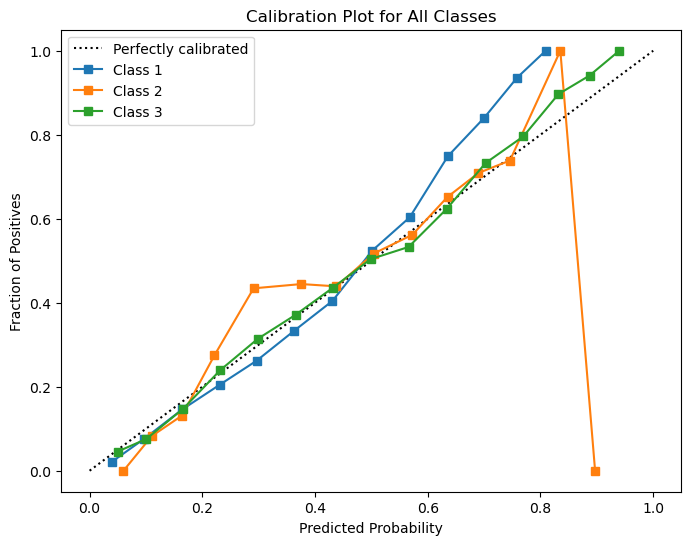

In [29]:
# Create a copy of the pipeline
pipe_poly = pipe
# Fit the pipeline to the training data with polynomial features
pipe_poly.fit(X_pol_train, y_train)

# Generate the calibration plot for the polynomial feature model
Calibrator(X_pol_test, y_test, pipe_poly)


The last point on the calibration curve shows a significant drop, it may be due to insufficient data for that point or the model overfitting on a small amount of data. Additionally, it is possible that the model needs additional hyperparameter tuning to improve its generalization performance.

### One-vs-One SGDClassifier Without Polynomial Features

In this section, we will train an One-vs-One SGDClassifier from sklearn.linear_model on the dataset without polynomial features. The SGDClassifier uses stochastic gradient descent, which is an optimization algorithm that can be used to train various models such as Support Vector Machines (SVM) and Logistic Regression. By specifying the 'loss' parameter as either 'hinge' or 'log', we can configure the SGDClassifier to train as an SVM or Logistic Regression, respectively. After training the model, we will calculate precision, recall, and f1-score, and average these metrics across all classes using micro, macro, and weighted averaging methods.

In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

In [31]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
# Train One-vs-One SGDClassifier
sgd_clf = SGDClassifier(loss='hinge', random_state=42)  # Choose 'hinge' for SVM or 'log' for LogReg
ovo_clf = OneVsOneClassifier(sgd_clf)
ovo_clf.fit(X_train_scaled, y_train)

OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

In [33]:
# Make predictions
y_pred = ovo_clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           1      0.738     0.528     0.615      5372
           2      0.625     0.864     0.725     11349
           3      0.754     0.533     0.624      9612

    accuracy                          0.675     26333
   macro avg      0.706     0.642     0.655     26333
weighted avg      0.695     0.675     0.666     26333



The results show that the One-vs-One SGDClassifier performs well for the classification task for this dataset. However, it should be noted that the metrics vary for different classes.

For class 1:

- Precision is 0.738, which means that out of all objects that the model identified as belonging to class 1, 73.8% actually belong to this class.
- Recall is 0.528, which means that the model correctly identified 52.8% of objects belonging to class 1.
- The F1-score is 0.615, which is the harmonic mean between precision and recall and represents the overall performance of the model for this class.

For class 2:

- Precision is 0.625, recall is 0.864, and the F1-score is 0.725.

For class 3:

- Precision is 0.754, recall is 0.533, and the F1-score is 0.624.

The overall accuracy of the model is 0.675, which means that 67.5% of objects were classified correctly. The macro avg metric takes into account the metrics of each class and averages them without taking into account the size of the class, while the weighted avg takes into account the size of the class when averaging. In this case, the macro avg for precision, recall, and F1-score are 0.706, 0.642, and 0.655, respectively, and the weighted avg is 0.695, 0.675, and 0.666.

Overall, the model shows good performance, but its effectiveness differs for different classes, especially for class 2. It may be worth trying other models or approaches to data processing to improve the results.

### Hyperparameter Tuning with GridSearchCV()

In this section, we will fine-tune the hyperparameters of the model using GridSearchCV(). We will explore different loss functions to train various types of models. For example, with `loss = 'hinge'`, we will train an SVM, and with `loss = 'log'`, we will train a logistic regression model. We will use cross-validation during the hyperparameter search, as we did previously, and evaluate the performance of the model on the test set by measuring the relevant metrics.

In [34]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creating an instance of One-vs-One SGDClassifier model
model = OneVsOneClassifier(SGDClassifier())

# Creating a parameter grid for GridSearchCV
param_grid = {'estimator__loss': ['hinge', 'log', 'modified_huber'],
              'estimator__penalty': ['l1', 'l2'],
              'estimator__alpha': [0.001, 0.01, 0.1]}

# Creating an instance of GridSearchCV
grid_search = GridSearchCV(model, param_grid, n_jobs=-1)

# Training the model on the data
grid_search.fit(X_train_scaled, y_train)

# Making predictions on the test set
y_pred = grid_search.predict(X_test_scaled)

# Printing the classification report
print(classification_report(y_test, y_pred, digits=3))

# Printing the best hyperparameters
print("Best parameters: ", grid_search.best_params_)

              precision    recall  f1-score   support

           1      0.747     0.530     0.620      5372
           2      0.632     0.847     0.724     11349
           3      0.747     0.567     0.645      9612

    accuracy                          0.680     26333
   macro avg      0.709     0.648     0.663     26333
weighted avg      0.697     0.680     0.674     26333

Best parameters:  {'estimator__alpha': 0.1, 'estimator__loss': 'modified_huber', 'estimator__penalty': 'l2'}


The classification report shows the results of the model's prediction on the test dataset. Let's go over each metric:

- **precision**: the proportion of true positive predictions out of all positive predictions. In your case, precision for class 1 is 0.747, for class 2 - 0.632, and for class 3 - 0.747.
    
- **recall**: the proportion of true positive predictions out of all actual positive instances. In your case, recall for class 1 is 0.530, for class 2 - 0.847, and for class 3 - 0.567.
    
- **f1-score**: the harmonic mean of precision and recall. This allows to take into account both metrics in one numerical evaluation. In your case, f1-score for class 1 is 0.620, for class 2 - 0.724, and for class 3 - 0.645.
    
- **support**: the number of actual instances for each class in the test dataset. In your case, support for class 1 is 5372, for class 2 - 11349, and for class 3 - 9612.
    
- **accuracy**: the overall proportion of true predictions. In your case, accuracy is 0.680.
    
- **macro avg**: the arithmetic mean of all metrics (precision, recall, f1-score) for all classes, without taking into account class size. In your case, macro avg is 0.709 for precision, 0.648 for recall, and 0.663 for f1-score.
    
- **weighted avg**: the arithmetic mean of all metrics (precision, recall, f1-score) for all classes, taking into account class size. In your case, weighted avg is 0.697 for precision, 0.680 for recall, and 0.674 for f1-score.
    

The best model parameters found with GridSearchCV are `alpha` equal to 0.1, `loss` equal to 'modified\_huber', and `penalty` equal to 'l2'.

# Conclusion
The primary goal was to predict surge_pricing_type with three classes (1, 2, and 3). The model's performance was evaluated using metrics like precision, recall, f1-score, and accuracy. **The overall accuracy of the model is 68%**, indicating it can predict surge_pricing_type with reasonable accuracy for about 68% of the cases.

The best parameters for the model were found using GridSearchCV, which optimized the model's hyperparameters. The weighted average precision, recall, and f1-score demonstrate the model's reasonable performance.